In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras import layers

In [12]:
# Directories
train_dirs = [
    '/content/drive/MyDrive/ProjetoIA/dataset/train1',
    '/content/drive/MyDrive/ProjetoIA/dataset/train2',
    '/content/drive/MyDrive/ProjetoIA/dataset/train4',
    '/content/drive/MyDrive/ProjetoIA/dataset/train5'
]
validation_dir = '/content/drive/MyDrive/ProjetoIA/dataset/train3'
test_dir = '/content/drive/MyDrive/ProjetoIA/dataset/test'

# Parameters
IMG_SIZE = 150
BATCH_SIZE = 32

# Function to load datasets from multiple directories and concatenate them
def load_and_concatenate_datasets(directories, img_size, batch_size):
    datasets = []
    for directory in directories:
        dataset = image_dataset_from_directory(
            directory,
            image_size=(img_size, img_size),
            batch_size=batch_size
        )
        datasets.append(dataset)
    return datasets

# Load train datasets and concatenate
train_datasets = load_and_concatenate_datasets(train_dirs, IMG_SIZE, BATCH_SIZE)
train_dataset = tf.data.Dataset.sample_from_datasets(train_datasets)

# Load validation and test datasets
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Extract class names from one of the datasets
example_dataset = image_dataset_from_directory(
    train_dirs[0],
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
class_names = example_dataset.class_names
print(class_names)

Found 10400 files belonging to 10 classes.
Found 9600 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 1 classes.
Found 10400 files belonging to 10 classes.
['000_airplane', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '009_truck']


In [13]:
# Build the model
conv_base = VGG16(weights="imagenet", include_top=False)
conv_base.trainable = True
for layer in conv_base.layers[:-2]:
    layer.trainable = False

In [14]:
inputs = keras.Input(shape=(150, 150, 3))
x = keras.applications.vgg16.preprocess_input(inputs)  # Apply input value scaling
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [15]:
# Fine tuning
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

In [16]:
# Adding ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/ProjetoIA/models/best_modelT_TL_FT_without_DA.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1)

In [17]:
# Train the model with fine-tuning and checkpointing
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[checkpoint_cb,early_stop]
)

# Save the final model
model.save('/content/drive/MyDrive/ProjetoIA/models/CNN_modelT_TL_FT_without_DA.h5')

Epoch 1/30
   1251/Unknown - 394s 314ms/step - loss: 4.1475 - accuracy: 0.4888
Epoch 1: val_loss improved from inf to 0.93821, saving model to /content/drive/MyDrive/ProjetoIA/models/best_modelT_TL_FT_without_DA.h5
1251/1251 [==============================] - 480s 383ms/step - loss: 4.1475 - accuracy: 0.4888 - val_loss: 0.9382 - val_accuracy: 0.7393
Epoch 2/30
1251/1251 [==============================] - ETA: 0s - loss: 1.2252 - accuracy: 0.6802
Epoch 2: val_loss improved from 0.93821 to 0.68712, saving model to /content/drive/MyDrive/ProjetoIA/models/best_modelT_TL_FT_without_DA.h5
1251/1251 [==============================] - 472s 377ms/step - loss: 1.2252 - accuracy: 0.6802 - val_loss: 0.6871 - val_accuracy: 0.7892
Epoch 3/30
1251/1251 [==============================] - ETA: 0s - loss: 0.8453 - accuracy: 0.7585
Epoch 3: val_loss improved from 0.68712 to 0.60882, saving model to /content/drive/MyDrive/ProjetoIA/models/best_modelT_TL_FT_without_DA.h5
1251/1251 [========================

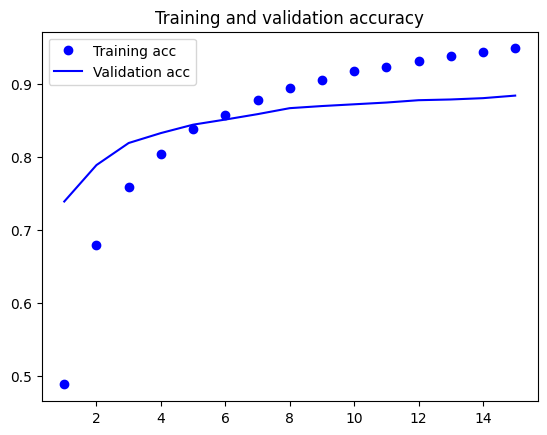

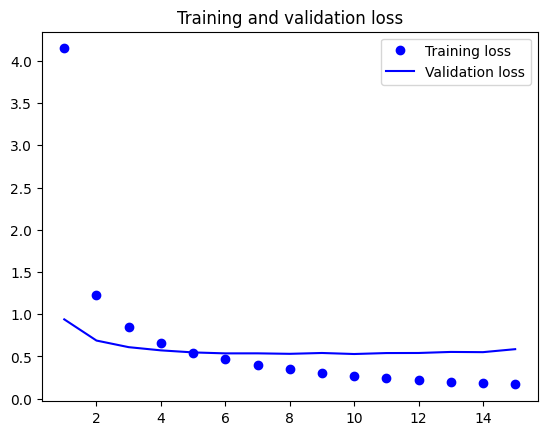

In [18]:
#Displaying curves of loss and accuracy

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
#Assessing the model’s performance
test_loss, test_acc = model.evaluate(validation_dataset)#devolve um tuplo, sao objetos individuais
print('test_acc:', test_acc)

313/313 [==============================] - 88s 281ms/step - loss: 0.5850 - accuracy: 0.8843
test_acc: 0.8842999935150146
